In [32]:
using Pkg, Revise, Lux, Random, DifferentialEquations, SciMLSensitivity, ComponentArrays, Plots, MLUtils, OptimizationOptimisers, LinearAlgebra, Statistics, Printf
using IterTools: ncycle
using NeuroDynamics

In this example, we will first generate data from a Hodking-Huxley model of single neurons driven by dynamic synaptic inputs. Then we will attempt to recover a model of the dynamics using a a latent neural ODE. 

## 1.Generating ground truth data 


### 1.1 Simulating Synaptic Inputs 

We will use the [Tsodyks-Markram model](https://www.pnas.org/doi/full/10.1073/pnas.94.2.719) to simulate the synaptic inputs to a neuron. We will generate multiple trajectories to later drive our Hodking-Huxley neuron model.

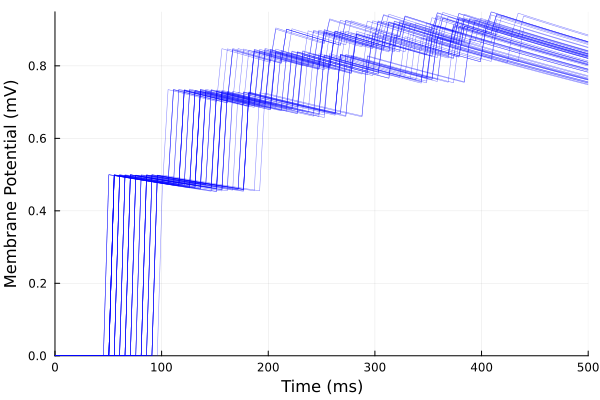

In [23]:
n_samples = 64
tspan = (0.0, 500.0)
ts = range(tspan[1], tspan[2], length=100)
p =  [30, 1000, 50, 0.5, 0.005]
function TMS(x, p, t)
    v, R, gsyn = x
    tau, tau_u, tau_R, v0, gmax = p 
    dx₁ = -(v / tau_u)
    dx₂ = (1 - R) / tau_R
    dx₃ = -(gsyn / tau)
    return vcat(dx₁, dx₂, dx₃)
end

function epsp!(integrator)
    integrator.u[1] += integrator.p[4] * (1 - integrator.u[1])
    integrator.u[3] += integrator.p[5] * integrator.u[1] * integrator.u[2]
    integrator.u[2] -= integrator.u[1] * integrator.u[2]
end
prob = ODEProblem(TMS, [0.0, 1.0, 0.0], tspan, p)
function prob_func(prob, i, repeat)
    t_start = rand(50:100)
    t_int = rand(50:100)
    t_end = rand(400:450)
    epsp_ts = PresetTimeCallback(t_start:t_int:t_end, epsp!, save_positions=(false, false))
    remake(prob, callback=epsp_ts)
end

ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
U = solve(ensemble_prob, Tsit5(),  EnsembleThreads(); saveat=ts, trajectories=n_samples);
plot(U, vars=(1), alpha=0.5, color=:blue, lw=0.5, legend=false, xlabel="Time (ms)", ylabel="Membrane Potential (mV)")


### 1.2 Simulating a Hodgkin-Huxley Neuron 

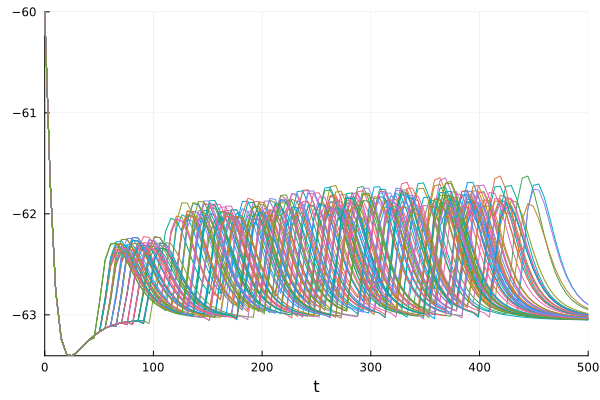

In [24]:
# Potassium ion-channel rate functions
alpha_n(v) = (0.02 * (v - 25.0)) / (1.0 - exp((-1.0 * (v - 25.0)) / 9.0))
beta_n(v) = (-0.002 * (v - 25.0)) / (1.0 - exp((v - 25.0) / 9.0))

# Sodium ion-channel rate functions
alpha_m(v) = (0.182 * (v + 35.0)) / (1.0 - exp((-1.0 * (v + 35.0)) / 9.0))
beta_m(v) = (-0.124 * (v + 35.0)) / (1.0 - exp((v + 35.0) / 9.0))

alpha_h(v) = 0.25 * exp((-1.0 * (v + 90.0)) / 12.0)
beta_h(v) = (0.25 * exp((v + 62.0) / 6.0)) / exp((v + 90.0) / 12.0)



function HH(x, p, t, u)
    gK, gNa, gL, EK, ENa, EL, C, ESyn, i = p
    v, n, m, h = x
    ISyn(t) = u[i](t)[end] * (ESyn - v)

    dx₁ = ((gK * (n^4.0) * (EK - v)) + (gNa * (m^3.0) * h * (ENa - v)) + (gL * (EL - v)) + ISyn(t)) / C
    dx₂ = (alpha_n(v) * (1.0 - n)) - (beta_n(v) * n)
    dx₃ = (alpha_m(v) * (1.0 - m)) - (beta_m(v) * m)
    dx₄ = (alpha_h(v) * (1.0 - h)) - (beta_h(v) * h)

    dx = vcat(dx₁, dx₂, dx₃, dx₄)
end

dxdt(x, p, t) = HH(x, p, t, U)

p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0, 1] 
# n, m & h steady-states
n_inf(v) = alpha_n(v) / (alpha_n(v) + beta_n(v))
m_inf(v) = alpha_m(v) / (alpha_m(v) + beta_m(v))
h_inf(v) = alpha_h(v) / (alpha_h(v) + beta_h(v))

v0 = -60
x0 = [v0, n_inf(v0), m_inf(v0), h_inf(v0)]
prob = ODEProblem(dxdt, x0, tspan, p)
prob_func(prob, i, repeat) = remake(prob, p=(p[1:end-1]..., i))
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
Y = solve(ensemble_prob, EnsembleThreads(); saveat=ts, trajectories=n_samples)
plot(Y, vars=1, label="v")


### 1.3 Creating a dataset and splitting it into train and test sets

In [25]:
Y_data = Array(Y) .|> Float32
U_data = Array(U) .|> Float32
input_dim = size(U_data)[1]
obs_dim = size(Y_data)[1]
(u_train, y_train), (u_val, y_val) = splitobs((U_data, Y_data); at=0.8, shuffle=true)
# Create dataloaders
train_loader = DataLoader((U_data, Y_data), batchsize=32, shuffle=false)
val_loader = DataLoader((U_data, Y_data), batchsize=32, shuffle=true);


In [60]:
function create_model(n_states, ctrl_dim, obs_dim, context_dim, t_init)
    rng = Random.MersenneTwister(1234)
    obs_encoder = Recurrent_Encoder(obs_dim, n_states, context_dim, 32, t_init)
    ctrl_encoder = NoOpLayer()
    vector_field = Chain(Dense(n_states+ctrl_dim, 32, softplus), Dense(32, n_states, tanh))
    dynamics = ODE(vector_field, Euler(); saveat=ts, dt=2.0)
    obs_decoder = Linear_Decoder(n_states, obs_dim, "None")   
    ctrl_decoder = NoOpLayer()

    model = LatentUDE(obs_encoder, ctrl_encoder, dynamics, obs_decoder, ctrl_decoder)
    p, st = Lux.setup(rng, model)
    p = p |> ComponentArray{Float32}
    return model, p, st
end

create_model (generic function with 1 method)

In [61]:
latent_dim = 8
context_dim = 0 # No need for context if we have ODE dynamics
t_init = 50
model, p, st = create_model(latent_dim, input_dim, obs_dim, context_dim, t_init)
u, y = first(train_loader)
ts = ts |> Array{Float32}
model(y, u, ts, p, st)

([-0.4089795192634399 7.3809014120404 … 270.44974534993366 272.66653158532677; 0.308545118714018 -6.502611532771001 … -853.5584367238237 -856.0163761125208; 0.6655329143159346 -3.538648476892417 … -702.6198216679584 -711.8082246635486; 0.15822472214402997 -0.14807619239050718 … -219.40946558391425 -225.4264407416985;;; 1.9979602335093758 7.2579138555006635 … 516.2713055449549 521.567904183632; 0.903209903253124 -2.998471004408156 … -428.92566962940697 -433.29091634849505; -0.10488948856808887 1.5361358092830106 … -529.534367103031 -535.001522101533; -2.3984696223434967 -1.7343437469675655 … -480.62452319423386 -485.61558992826787;;; -0.5532915672849055 5.909847220313939 … 368.4273468598124 376.98680060755555; 0.07341020041970459 -6.89017630435955 … -436.4530168454244 -440.1928230127924; 1.7630153885478748 0.1332154920955424 … -375.07397950290095 -377.5039857845424; 2.222645791250472 2.3224532691214823 … -222.13531128610788 -222.97848709433305;;; … ;;; 3.1177650922865983 7.9511264929137

In [62]:
function train(model, p, st, train_loader, val_loader, epochs, print_every)
    
    epoch = 0
    L = frange_cycle_linear(epochs+1, 0.0f0, 1.0f0, 1, 0.5)
    losses = []
    best_model_params = nothing
    best_metric = Inf
    function loss(p, u, y, ts=ts)
        ŷ, û, x̂₀, _ = model(y, u, ts, p, st)
        batch_size = size(y)[end]
        recon_loss = mse(ŷ[1:1, :, :], y[1:1, :, :])/batch_size
        kl_loss = kl_normal(x̂₀[1], x̂₀[2])/batch_size
        l =  0.1*recon_loss + L[epoch+1]*kl_loss
        return l, recon_loss, kl_loss
    end


    callback = function(opt_state, l, recon_loss, kl_loss)
        θ = opt_state.u
        push!(losses, l)
        if length(losses) % length(train_loader) == 0
            epoch += 1
        end

        if length(losses) % (length(train_loader)*print_every) == 0
            @printf("Current epoch: %d, Loss: %.2f, Reconstruction: %d, KL: %.2f\n", epoch, losses[end], recon_loss, kl_loss)
            u, y = first(train_loader)
            batch_size = size(y)[end]
            ŷ, _, x = predict(model, y, u, ts, θ, st, 20)
            ŷ_mean = dropdims(mean(ŷ, dims=4), dims=4)
            val_mse = mse(ŷ_mean[1:1, :, :], y[1:1, :, :])
            @printf("Validation MSE: %.2f\n", val_mse)
            if val_mse < best_metric
                best_metric = val_mse
                @printf("Saving model with best metric: %.2f\n", best_metric)
                best_model_params = copy(θ)

            end

            pl = plot(transpose(y[1:1, :, 1]), label="True", lw=2.0)
            plot!(pl, transpose(ŷ_mean[1:1, :, 1]), label="Predicted", lw=2.0, xlabel="Time (ms)", ylabel="Membrane Potential (mV)")
            display(pl)
        
        end
        return false
    end

    adtype = Optimization.AutoZygote()
    optf = OptimizationFunction((p, _ , u, y) -> loss(p, u, y), adtype)
    optproblem = OptimizationProblem(optf, p)
    result = Optimization.solve(optproblem, ADAMW(1e-3), ncycle(train_loader, epochs); callback)
    return result, losses, model, best_model_params
    
end


train (generic function with 1 method)

Current epoch: 20, Loss: 1386.65, Reconstruction: 13858, KL: 2.21
Validation MSE: 448799.32
Saving model with best metric: 448799.32
Current epoch: 40, Loss: 451.44, Reconstruction: 4497, KL: 2.30
Validation MSE: 151438.48
Saving model with best metric: 151438.48
Current epoch: 60, Loss: 336.59, Reconstruction: 3332, KL: 3.39
Validation MSE: 109403.25
Saving model with best metric: 109403.25
Current epoch: 80, Loss: 337.26, Reconstruction: 3336, KL: 3.63
Validation MSE: 111677.66
Current epoch: 100, Loss: 348.38, Reconstruction: 3456, KL: 2.78
Validation MSE: 107867.48
Saving model with best metric: 107867.48


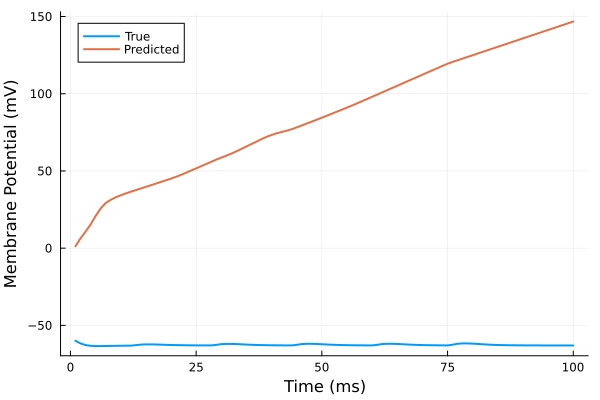

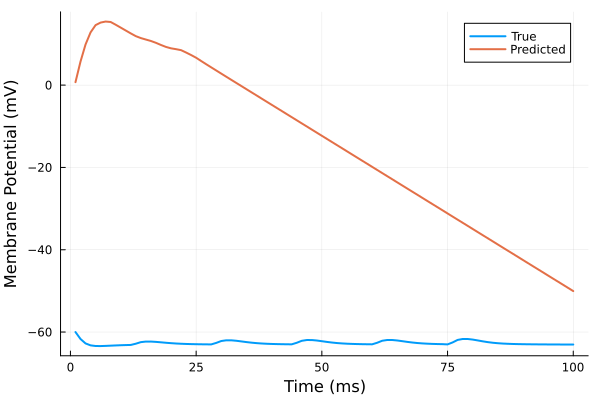

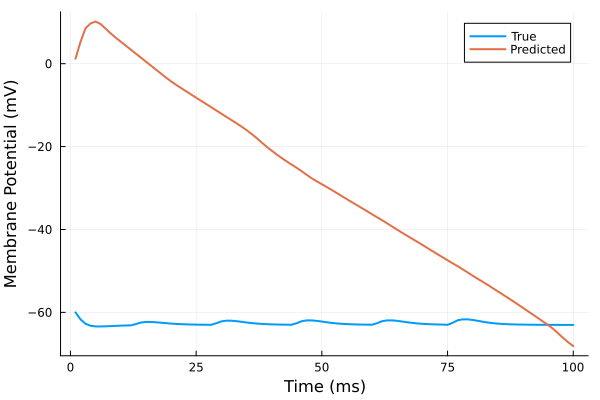

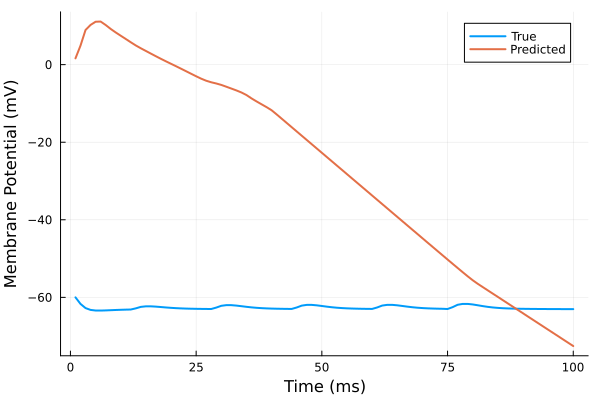

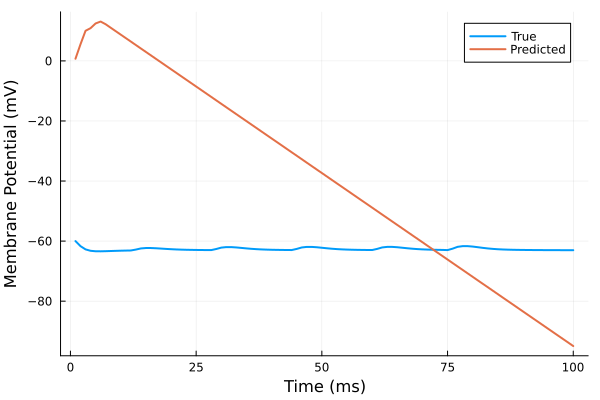

(retcode: Default
u: (obs_encoder = (linear_net = (weight = Float32[-0.3995537 0.0131838415 -0.38256955 -0.31189945; 0.30927733 -0.074356705 -0.03222353 -0.017620234; … ; 0.20887157 0.068692155 -0.3727682 -0.009562765; -0.39576137 -0.24763803 0.068774104 0.14111972], bias = Float32[0.00012252777; 0.006120074; … ; -0.00621791; -0.0041998466;;]), init_net = (layer_1 = Float32[], layer_2 = (weight_i = Float32[0.0431614 0.16242296 … 0.29096797 0.19129123; 0.28538278 0.030611293 … 0.2686293 0.06480691; … ; -0.14582388 0.07442577 … 0.19433127 0.24275121; 0.1711852 0.16621524 … 0.009793227 -0.26860765], weight_h = Float32[-0.20750257 0.22646934 … -0.21870223 -0.034701; -0.16371031 0.19429612 … 0.13267575 -0.08001802; … ; 0.25138658 -0.12467162 … 0.2756143 0.29289687; 0.07866707 0.026271826 … 0.15409978 -0.15612854], bias = Float32[-6.4001746f-5; 0.0; … ; -0.0007696244; -0.0048229666;;]), layer_3 = (layer_1 = (weight = Float32[0.37455574 -0.27857682 … 0.06402332 -0.043261133; -0.062780924 0.30

In [63]:
result, losses, model, best_p = train(model, p, st, train_loader, val_loader, 100, 20)
